In [11]:

import yaml
import os
import torch
import numpy as np

script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..',  'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
    config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')

if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'

print(config)


{'model': {'hidden_dim': 96, 'epochs': 200, 'lr': 0.005, 'dropout': 0.3, 'alpha': 0.7, 'device': 'cpu', 'latent_dim': 48, 'ddpm_timesteps': 400, 'ddpm_loss_weight': 0.6, 'l2_reg': 5e-05, 'seed': 123}}


In [12]:
#Insert Dataset
from pygod.generator import gen_contextual_outlier, gen_structural_outlier
from torch_geometric.datasets import AttributedGraphDataset
from torch_geometric.datasets import Planetoid
from typing import List
import copy

string = "Cora"
#string = "Wiki"
#string = "Facebook"

dataset = AttributedGraphDataset(root = "data/"+string, name = string)
dataset = Planetoid(root = "data/"+string, name = string)


data = dataset[0]

clean_data = copy.deepcopy(data)

amount_of_nodes = data.num_nodes

seed = 123
num_nodes_to_inject = round(amount_of_nodes * 0.05)
num_nodes_per_clique = 8
# Tested for 15, stabilizing at 41 for 5 targets
# Tested for 10, stabilizing at 33 for 5 targets
num_cliques = round((num_nodes_to_inject / 2) / num_nodes_per_clique)
num_contextual_outliers = num_nodes_to_inject - num_cliques * num_nodes_per_clique

data, ya = gen_contextual_outlier(data, n = num_contextual_outliers, k = 50, seed = seed) 
#n (int) – Number of nodes converting to outliers.
#k (int) – Number of candidate nodes for each outlier node.

data, ys = gen_structural_outlier(data, m = num_nodes_per_clique, n = num_cliques, p = 0.2, seed = seed)
#m (int) - Number nodes in the outlier cliques.
#n (int) - Number of outlier clique
data_classes = data.y

data.y = torch.logical_or(ys, ya).long()
y_binary: List[int] = data.y.bool()
anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide

print("Previous: ", clean_data)
print(clean_data.edge_index)
print("ours", data)

pygod = False
if (pygod):
    from pygod.utils import load_data
    data = load_data("inj_cora")
    y_binary: List[int] = data.y.bool()

    anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide

    print("pygod", data)


from gad_adversarial_robustness.utils.graph_utils import prepare_graph

amount_of_nodes = data.num_nodes
labels = data_classes
features = data.x
_, adj, _ = prepare_graph(data) #Get adjacency matrix




Previous:  Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])
tensor([[ 163,  163,  163,  ..., 1887, 1902,  837],
        [ 402,  659, 1696,  ..., 2258, 1887, 1686]])
ours Data(x=[2708, 1433], edge_index=[2, 5787], y=[2708])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([   8,  435,  544,  ...,  774, 1389, 2344]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=5787, density=0.08%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])


In [13]:

def convertToTriple(data):
    _, adj, _ = prepare_graph(data) #Get adjacency matrix

    n = data.num_nodes

    # 'triple' is a list that will store the perturbed triples during the poisoning process.
    # Each triple represents an edge modification in the form of (node1, node2, edge_label).

    dense_adj = adj.to_dense()
    
    A = np.array(dense_adj)

    triple = []
    for i in range(n):
        for j in range(i+1,n):
        #for j in range(n)
            triple.append([i,j,A[i,j]])
    triple = np.array(triple)

    return triple

triple = convertToTriple(data)
print(triple)
print(triple.shape)

count = 0
for i in range(len(triple)):
    if (triple[i][2] != 0):   #If edge value is not 0 (no edge)
        count += 1
print("count", count)


tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([   8,  435,  544,  ...,  774, 1389, 2344]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=5787, density=0.08%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])
[[0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 2.000e+00 0.000e+00]
 [0.000e+00 3.000e+00 0.000e+00]
 ...
 [2.705e+03 2.706e+03 0.000e+00]
 [2.705e+03 2.707e+03 0.000e+00]
 [2.706e+03 2.707e+03 0.000e+00]]
(3665278, 3)
count 3178


In [14]:
from torch_geometric.utils import to_undirected
#data = copy.deepcopy(clean_data)
print(data.edge_index)
print(data)
data.edge_index = to_undirected(data.edge_index)
print(data.edge_index)
print(data)
def convertToTriple(data):
    _, adj, _ = prepare_graph(data) #Get adjacency matrix

    n = data.num_nodes

    # 'triple' is a list that will store the perturbed triples during the poisoning process.
    # Each triple represents an edge modification in the form of (node1, node2, edge_label).

    dense_adj = adj.to_dense()
    
    A = np.array(dense_adj)

    triple = []
    for i in range(n):
        for j in range(i+1, n):
        #for j in range(n)
            triple.append([i,j,A[i,j]])
    triple = np.array(triple)

    return triple

triple = convertToTriple(data)
print(triple)
print(triple.shape)

count = 0
for i in range(len(triple)):
    if (triple[i][2] != 0):   #If edge value is not 0 (no edge)
        count += 1
print("count", count)


tensor([[ 163,  163,  163,  ...,  382,  893,  106],
        [ 402,  659, 1696,  ..., 2008, 2598, 1995]])
Data(x=[2708, 1433], edge_index=[2, 5787], y=[2708])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   8,   14,  258,  ...,  774, 1389, 2344]])
Data(x=[2708, 1433], edge_index=[2, 10914], y=[2708])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([   8,   14,  258,  ...,  774, 1389, 2344]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=10914, density=0.15%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])
[[0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 2.000e+00 0.000e+00]
 [0.000e+00 3.000e+00 0.000e+00]
 ...
 [2.705e+03 2.706e+03 0.000e+00]
 [2.705e+03 2.707e+03 0.000e+00]
 [2.706e+0

In [15]:

from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.utils import to_torch_sparse_tensor


adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])


adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
#attrs = torch.FloatTensor(attrs)

edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])


sparse_adj = to_torch_sparse_tensor(edge_index)


dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)


In [16]:
#Pleaseee   
data_anom = copy.deepcopy(data)

from gad_adversarial_robustness.poison.grad_max_attack import grad_max_attack
amount = 1
budget = 10
target = anomaly_list[:amount]
print("target", target)
triple, AS, list_of_perturbs, struc, loss = grad_max_attack(data, target, budget, config, models_to_test=[], debug = True)

target [3]
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([   8,   14,  258,  ...,  774, 1389, 2344]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=10914, density=0.15%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])
initial AS: 2.678758274225498
iter 1 AS: 1.3288711293231374 perturb: [3, 811]
iter 2 AS: 0.6393868190134864 perturb: [3, 1271]
iter 3 AS: 0.10464342577471088 perturb: [3, 1531]
iter 4 AS: 1.4219924938447817 perturb: [3, 464]
iter 5 AS: 0.957345667924544 perturb: [3, 1108]
iter 6 AS: 0.44181391695342764 perturb: [3, 197]
iter 7 AS: 0.12966010194750602 perturb: [3, 463]
iter 8 AS: 0.803125356670744 perturb: [1414, 1668]
iter 9 AS: 0.35812911685920934 perturb: [3, 1414]
iter 10 AS: 0.

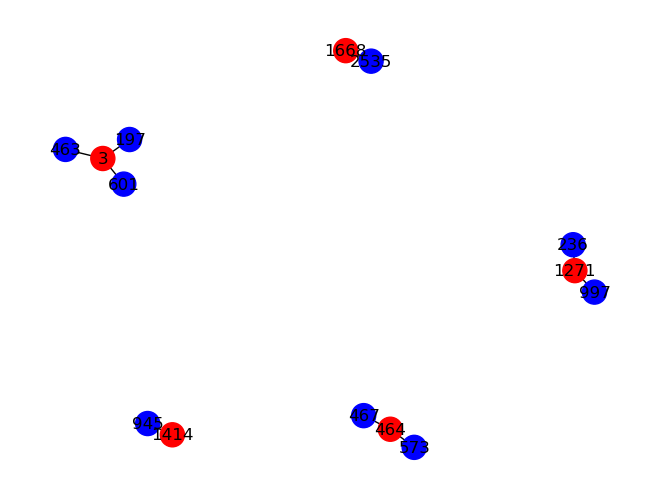

In [22]:
from gad_adversarial_robustness.utils.visualizations import plot_node_subgraph

target_nodes = torch.tensor([target[0]])
target_nodes = torch.tensor([1108, 464, 1414, 1668, 811, 1271, 1531, 3])


def tempPlot(data):
    data = copy.deepcopy(data)
    edge_index = data.edge_index
    edge_index = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.size(dim = 1)))
    edge_index = edge_index.coalesce()

    plot_node_subgraph(edge_index, target_nodes, anomaly_list = anomaly_list, with_labels=True)

tempPlot(clean_data)


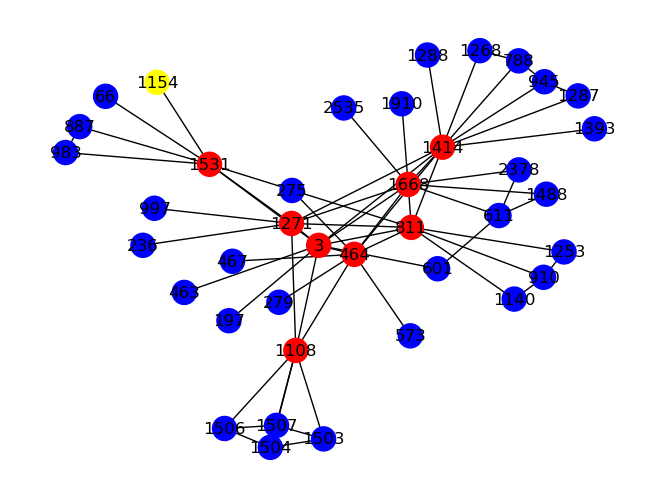

In [23]:

tempPlot(data_anom)


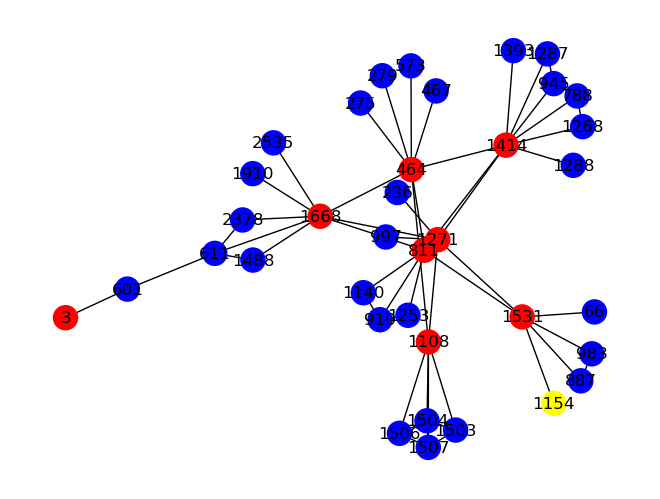

In [24]:

def convertFromTriple(triple):
    # Create Edge Index'
    edge_index = torch.tensor([[],[]])

    # Transpose it to make shape compatible
    transposed_adj_adversary = torch.transpose(triple, 0, 1)
    count = 0
    for i in range(len(triple)):
        if(triple[i][2] != 0):   #If edge value is not 0 (no edge)
            count += 1
            #Add edge to edge index, choosing first 2 elements (edges), and then the ith edge
            edge_index = torch.cat((edge_index, transposed_adj_adversary[:2, i:i+1]), -1)
            # Dataset uses edges both ways so add reverse edge as well
            edge_index = torch.cat((edge_index, torch.flip(transposed_adj_adversary[:2, i:i+1], dims=[0])), -1)
    print (count)
    return edge_index

data.edge_index = convertFromTriple(torch.from_numpy(triple))

tempPlot(data)

In [85]:
print(list_of_perturbs)

edge = data.edge_index

def convertFromPerturb(data, list_of_perturbs):
    edge_data = data.edge_index
    for change in list_of_perturbs:
        print(f'Change: {change}')
        #if (change[2] == 1):    #If to add edge
        if (True):
            edge_data = torch.cat((edge_data, torch.tensor([[change[0], change[1]], [change[1], change[0]]])), -1)
            print(edge_data)
        else:   #Delete edge
            for i in reversed(range(edge_data.size(dim = 1))):   #Cycle through all edges in reverse, if matches delete
                if ((edge_data[0][i] == change[0] and edge_data[1][i] == change[1]) or
                    (edge_data[0][i] == change[1] and edge_data[1][i] == change[0])):
                    edge_data = torch.cat((edge_data[:, :i], edge_data[:, i+1:]), axis = 1)

    data.edge_index = edge_data
    return data

# Perturb method

data = convertFromPerturb(copy.deepcopy(data_anom), list_of_perturbs)

print(data_anom)
print(data)

print([163, 402] in data.edge_index)


[[1625, 2707]]
Change: [1625, 2707]
tensor([[ 163,  163,  163,  ..., 2707, 1625, 2707],
        [ 402,  659, 1696,  ..., 1625, 2707, 1625]])
Data(x=[2708, 1433], edge_index=[2, 6285], y=[2708])
Data(x=[2708, 1433], edge_index=[2, 6287], y=[2708])


RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'list'>.

In [149]:
import math

def convertFromTriple(triple):
    # Create Edge Index'
    edge_index = torch.tensor([[],[]])

    # Transpose it to make shape compatible
    transposed_adj_adversary = torch.transpose(triple, 0, 1)
    count = 0
    for i in range(len(triple)):
        if(triple[i][2] != 0):   #If edge value is not 0 (no edge)
            count += 1
            #Add edge to edge index, choosing first 2 elements (edges), and then the ith edge
            edge_index = torch.cat((edge_index, transposed_adj_adversary[:2, i:i+1]), -1)
            # Dataset uses edges both ways so add reverse edge as well
            edge_index = torch.cat((edge_index, torch.flip(transposed_adj_adversary[:2, i:i+1], dims=[0])), -1)
    print (count)
    return edge_index

def convertFromTriple2(triple):
    triple = torch.from_numpy(triple)
    triple = torch.transpose(triple, 0, 1)

    print(triple.size())
    triple = triple[2]
    print(triple.size())
    len = math.sqrt(triple.size()[0])
    print(len)
    dense = torch.reshape(triple, (len, len))

    #edge_index = torch.reshape(triple, (2, -1))
    # edge_index = torch.from_numpy(triple)
    # edge_index = edge_index.to_sparse()

    edge_index = 0
    return edge_index

print(triple)
data.edge_index = convertFromTriple(torch.from_numpy(triple))



print(data.edge_index)
#edge = convertFromTriple(triple)


[[0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 2.000e+00 0.000e+00]
 [0.000e+00 3.000e+00 0.000e+00]
 ...
 [2.705e+03 2.706e+03 0.000e+00]
 [2.705e+03 2.707e+03 0.000e+00]
 [2.706e+03 2.707e+03 0.000e+00]]
5551
tensor([[   0.,    8.,    0.,  ..., 2700., 2698., 2700.],
        [   8.,    0.,   14.,  ..., 2697., 2700., 2698.]], dtype=torch.float64)


In [150]:
print(clean_data)
print(data_anom)
print(data)

print("triple", triple.size)

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])
Data(x=[2708, 1433], edge_index=[2, 11186], y=[2708])
Data(x=[2708, 1433], edge_index=[2, 11102], y=[2708])
triple 10995834


In [39]:
#Test
a = torch.arange(9)

a = torch.reshape(a, (3, 3))
print(a)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


In [2]:
# %% 
from gad_adversarial_robustness.utils.graph_utils import top_anomalous_nodes, load_injected_dataset, get_top_k_anomalies, get_anomalies_with_label_1
from gad_adversarial_robustness.poison.greedy import greedy_attack_with_statistics
import os
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.optim.sgd import SGD
from torch.optim.optimizer import required
import torch
import numpy as np
import scipy.sparse as sp
#from pygod.detector import DOMINANT
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, adj_matrix_sparse_coo_to_dense
from gad_adversarial_robustness.utils.experiment_results import Experiment
import torch
from pygod.utils import load_data
import copy
from typing import Tuple, List, Any
import yaml
import os
from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.gad.dominant.dominant_cuda_sage import Dominant as DominantAgg
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_torch_sparse_tensor
from gad_adversarial_robustness.poison.greedy import multiple_AS
from gad_adversarial_robustness.utils.graph_utils import get_n_anomaly_indexes
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score
)
from gad_adversarial_robustness.gad.OddBall_vs_DOMININANT import get_OddBall_AS

USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET = False
USE_ODDBALL_AS_TO_SELECT_TOP_K_TARGET = True
TOP_K = 20
DATASET_NAME = 'inj_cora'
print(DATASET_NAME)
GRAPH_PARTITION_SIZE = None

script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..',  'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')


if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'

if DATASET_NAME == 'inj_cora' or DATASET_NAME == 'inj_amazon':
    dataset: Data = load_data(DATASET_NAME)
elif DATASET_NAME == 'Wiki' or DATASET_NAME == 'Cora' or DATASET_NAME == 'Facebook':
    dataset: Data = load_injected_dataset(DATASET_NAME)

if GRAPH_PARTITION_SIZE is not None:
    subset = torch.randperm(dataset.num_nodes)[:GRAPH_PARTITION_SIZE]
    dataset = dataset.subgraph(subset)

print("TEST")
print(dataset.num_nodes)


adj, _, _, adj_label = load_anomaly_detection_dataset(dataset, config['model']['device'])
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])
#sparse_adj = to_torch_sparse_tensor(edge_index)

y_binary: List[int] = dataset.y.bool()
print(y_binary)

anomaly_list = get_n_anomaly_indexes(y_binary, TOP_K)
#anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide

print(anomaly_list)

_, adj, _ = prepare_graph(dataset)

amount_of_nodes = dataset.num_nodes

# 'triple' is a list that will store the perturbed triples during the poisoning process.
# Each triple represents an edge modification in the form of (node1, node2, edge_label).

dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges

np_dense_adj = np.array(dense_adj)
print("Create poison compatible adjacency matrix...")
triple = []
for i in range(amount_of_nodes):
    for j in range(i + 1, amount_of_nodes):
        triple.append([i, j, np_dense_adj[i,j]])  #Fill with 0, then insert actual after

triple = np.array(triple)



# %%

##
## DOMINANT UNMODIFIED
##
print("Before poison:")
testingModel = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label)
testingModel.to(config['model']['device'])
testingModel.fit(config, verbose=False, top_k=TOP_K)

if USE_DOMINANT_AS_TO_SELECT_TOP_K_TARGET:
    print("TOP K_AS:")
    print(testingModel.top_k_AS) 
    target_list = np.array(testingModel.top_k_AS)
elif USE_ODDBALL_AS_TO_SELECT_TOP_K_TARGET:
    target_list_as = get_OddBall_AS(data=dataset, device=config['model']['device'])
    target_list_as = np.array(target_list_as)
    labels_np = label.cpu().detach().numpy()
    print("ALL:")
    get_anomalies_with_label_1(target_list_as, labels_np)
    print("NOT ALL:")
    target_list = get_top_k_anomalies(target_list_as, labels_np, TOP_K, print_scores=True)
    print(f'Target list: {target_list}')
else:
    target_list = anomaly_list


print("Making model...")
model = multiple_AS(target_lst = target_list, n_node = amount_of_nodes, device = config['model']['device'])

#budget = target_list.shape[0] * 2  # The amount of edges to change

budget = TOP_K * 2

print("Starting attack...")
"""
# -------------
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)

_, AS, AS_DOM, AUC_DOM, ACC_DOM, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)
# -------------
"""

dom_model_1 = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label)



False
None
inj_cora
TEST
2708
tensor([False, False, False,  ..., False, False, False])
Anomalies indexes: [ 10  50  70  76 104 124 127 143 151 170 179 181 196 214 217 224 227 287
 289 294]
[ 10  50  70  76 104 124 127 143 151 170 179 181 196 214 217 224 227 287
 289 294]
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=11054, density=0.15%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])
Create poison compatible adjacency matrix...
Before poison:
Epoch: 0199, Auc: 0.8230728021203405
Top 20 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 2.94154953956604
Node ID: 1986, Anomaly Score:

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
_, AS_1, AS_DOM_1, AUC_DOM_1, ACC_DOM_1, perturb_1, edge_index_1, CHANGE_IN_TARGET_NODE_AS_1 = greedy_attack_with_statistics(
    model, triple, dom_model_1, config, target_list, budget, print_stats = True)


In [1]:
# From https://github.com/zhuyulin-tony/BinarizedAttack/blob/main/src/Greedy.py

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.utils import to_edge_index, dense_to_sparse, to_dense_adj
from copy import deepcopy

import argparse
import os
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
#from torch_sparse import SparseTensor
from scipy.sparse import csr_matrix


from gad_adversarial_robustness.poison.base_classes import BasePoison

from gad_adversarial_robustness.gad.dominant.dominant_cuda import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.utils.convert import from_scipy_sparse_matrix

class multiple_AS(nn.Module):
    def __init__(self, target_lst, n_node, device):
        """
            target_lst (numpy.ndarray): The target list to be initialized.
            n_node (int): The number of nodes.  
            device (str): The device to be used.
        """
        super().__init__()
        self.lst = target_lst
        self.n = n_node
        self.device = device
    
    def adjacency_matrix(self, tri):
        A = torch.sparse_coo_tensor(tri[:,:2].T, tri[:,2], size=[self.n,self.n]).to_dense()
        A = A + A.T - torch.diag(torch.diag(A)) # symmetric.
        return A
    
    def sparse_matrix_power(self, A, tau):
        A_sp = A.to_sparse()
        A_sp = torch.sparse_coo_tensor(A_sp.indices(), A_sp.values(), size=[self.n,self.n])
        return torch.sparse.mm(torch.sparse.mm(A_sp, A_sp), A_sp).to_dense()
    
    def extract_NE(self, A):    # Extract node and edge information based on adjecency matrix
        N = torch.sum(A, 1)
        E = torch.sum(A, 1) + 0.5 * torch.diag(self.sparse_matrix_power(A, 3)).T
        N = N.reshape(-1,1).to(self.device)
        E = E.reshape(-1,).to(self.device)
        return N, E
    
    def OLS_estimation(self, N, E):
        """
        OLS estimation function that calculates the Ordinary Least Squares estimate.
        
        Parameters:
            N (tensor): Input tensor for independent variable N (node)
            E (tensor): Input tensor for dependent variable E (edge)
        
        Returns:
            tensor: Tensor result of the OLS estimation
        """
        logN = torch.log(N + 1e-20).to(self.device)
        logE = torch.log(E + 1e-20).to(self.device)
        logN1 = torch.cat((torch.ones((len(logN),1)).to(self.device), logN), 1)
        return torch.linalg.pinv(logN1) @ logE
        
    def forward(self, tri): # Calculate the loss function / How much the output deviates from expected least squares estimate
        A = self.adjacency_matrix(tri)
        N, E = self.extract_NE(A)
        theta = self.OLS_estimation(N, E)
        b = theta[0] # Intercept
        w = theta[1] # Coefficient
        tmp = 0.
        for i in range(len(self.lst)):
            tmp += (torch.exp(b) * (N[self.lst[i]]**w) - E[self.lst[i]])**2 # Accumulate squared difference between expected (b * N[i]**w) and actual E[i]
        return tmp
    
    def true_AS(self, tri): # Calculate the true anomaly score by using OLS (Page 3 https://arxiv.org/pdf/2106.09989.pdf)
        # Originally from https://www.cs.cmu.edu/~christos/courses/826.F11/CMU-ONLY/oddball.pdf
        # Or https://www.researchgate.net/profile/Leman-Akoglu/publication/220894884_OddBall_Spotting_Anomalies_in_Weighted_Graphs/links/0fcfd50b2ea00b30d2000000/OddBall-Spotting-Anomalies-in-Weighted-Graphs.pdf

        A = self.adjacency_matrix(tri)
        N, E = self.extract_NE(A)

        theta = self.OLS_estimation(N, E)
        b = theta[0] # Intercept
        w = theta[1] # Coefficient
        tmp = 0.
        for i in range(len(self.lst)):
            tmp += (torch.max(E[self.lst[i]],torch.exp(b)*(N[self.lst[i]]**w))\
                   /torch.min(E[self.lst[i]],torch.exp(b)*(N[self.lst[i]]**w)))*\
                    torch.log(torch.abs(E[self.lst[i]]-torch.exp(b)*(N[self.lst[i]]**w))+1)
        return tmp

def update_adj_matrix_with_perturb(adj_matrix, perturb):
    """
        A faster way of converting perturbations to the edge_data

        Parameters: 
        - adj_matrix: The adjacency matrix in sparse
        - perturb: The perturbations to be added

        Returns:
        - adj_matrix: The updated adjacency matrix in sparse
    """
    adj_matrix = to_dense_adj(adj_matrix)
    #adj_matrix = adj_matrix.to_dense()
    if adj_matrix.ndim == 3:
        adj_matrix = adj_matrix[0]
    
    print("DENSE SHAPE:")
    print(adj_matrix[0].shape)

    for change in perturb:
        print(f'Change: {change}')
        adj_matrix[change[0], change[1]] = change[2]
        adj_matrix[change[1], change[0]] = change[2]
    

    print(adj_matrix.shape)
    adj_matrix = dense_to_sparse(adj_matrix)[0]
    print(adj_matrix.shape)
    return adj_matrix


        
def update_edge_data_with_perturb(edge_data, perturb):
    """
        A faster way of converting perturbations to the edge_data

        Parameters: 
        - edge_data: The edge_data to be updated in pytorch format
        - perturb: The perturbations to be added

        Returns:
        - edge_data: The updated edge_data
    """
    
    for change in perturb:
        if (change[2] == 1):    #If to add edge
            edge_data = torch.cat((edge_data, torch.tensor([[change[0], change[1]], [change[1], change[0]]])), -1)
        else:   #Delete edge

            for i in reversed(range(edge_data.size(dim = 1))):   #Cycle through all edges in reverse, if matches delete
                if ((edge_data[0][i] == change[0] and edge_data[1][i] == change[1]) or
                    (edge_data[0][i] == change[1] and edge_data[1][i] == change[0])):
                    edge_data = torch.cat((edge_data[:, :i], edge_data[:, i+1:]), axis = 1)
        
    return edge_data

def target_node_mask(target_list, tuple_list):
    """
        Takes a targetlist, and a tensor list. Returns a numpy array
    """
    new_list = []
    for index in target_list:
        new_list.append(tuple_list[index])
    
    return new_list
def get_DOMINANT_eval_values(model, config, target_list, perturb, iteration = None):
    """
        parameters:
        - model: The DOMINANT model
        - config: The config of the DOMINANT model
        - target_list: List of target nodes
        - perturb: perturbations

        returns:
        - AS_DOM: List of the anomaly score according to DOMINANT
        - AUC_DOM: AUC value according to DOMINANT
        - ACC_DOM: AUC value only considering target nodes, according to DOMINANT
    """
    deepcopy_model = copy.deepcopy(model)

    #torch.save(deepcopy_model.state_dict(), 'model.pt')

    #model.edge_index = update_edge_data_with_perturb(model.edge_index, perturb)
    deepcopy_model.edge_index = update_adj_matrix_with_perturb(deepcopy_model.edge_index, perturb)
    
    deepcopy_model.to(config['model']['device'])
    deepcopy_model.fit(config, verbose=False)


    target_nodes_as = target_node_mask(target_list=target_list, tuple_list=deepcopy_model.score)
    print("All target nodes as:")
    for node in target_nodes_as:
        print(node)
    print("================================")
    AS_DOM = np.sum(target_nodes_as)
    #AS_DOM = np.sum(model.score)
    AUC_DOM = roc_auc_score(deepcopy_model.label.detach().cpu().numpy(), deepcopy_model.score)
    ACC_DOM = 0
    #ACC_DOM = roc_auc_score(target_node_mask(model.label, target_list), target_node_mask(model.score, target_list))

    #model.load_state_dict(torch.load('model.pt'))

    return AS_DOM, AUC_DOM, ACC_DOM, target_nodes_as

def greedy_attack_with_statistics(model: multiple_AS, triple, DOMINANT_model, config, target_list, B, CPI = 1, print_stats = False):
    """
        Parameters: 
        - model: The surrogate model
        - triple: The edge_data to be posioned in triple form
        - DOMINANT_model: The DOMINANT model
        - config: The config of the DOMINANT model
        - target_list: List of target nodes
        - B: The number of perturbations
        - CPI: The number of perturbations per iteration
        - print_stats: Whether to print the anomaly score and changed edge after each perturbation

        Returbs:
        - triple: The poisoned edge_data
        - AS: List of the anomaly score after each perturbation according to surrogate model
        - AS_DOM: List of anomaly score after each perturbation according to DOMINANT
        - AUC_DOM: AUC value after each perturbation according to DOMINANT
        - ACC_DOM: Accuracy of the predicting the target nodes
        - perturb: List of the changed edges
        - edge_index: The edge_index of the poisoned graph, converted to torch format
    """
    triple_copy = triple.copy()
    # print(f'triple copy type: {type(triple_copy)}')
    triple_torch = Variable(torch.from_numpy(triple_copy), requires_grad = True) 
    AS = []
    AS_DOM = []
    AUC_DOM = []
    ACC_DOM = []
    CHANGE_IN_AS_TARGET_NODE_AS = []
    perturb = []
    print("True AS")
    print(model.true_AS(triple_torch).detach().cpu().numpy()[0])
    print(model.true_AS(triple_torch).detach().cpu().numpy())
    print("After AS")
    AS.append(model.true_AS(triple_torch).detach().cpu().numpy()[0])
    AS_DOM_temp, AUC_DOM_temp, ACC_DOM_temp, target_nodes_as = get_DOMINANT_eval_values(DOMINANT_model, config, target_list, perturb)
    CHANGE_IN_AS_TARGET_NODE_AS.append(target_nodes_as)
    AS_DOM.append(AS_DOM_temp)
    AUC_DOM.append(AUC_DOM_temp)
    ACC_DOM.append(ACC_DOM_temp)
    if(print_stats): print('initial anomaly score:', model.true_AS(triple_torch).detach().cpu().numpy()[0])
    
    i = 0
    count = 0
    while i < B:   #While we have not reached the maximum number of perturbations
        count += 1
        print("Perturbation number:", count)
        
        loss = model.forward(triple_torch)
        loss.backward()
        
        tmp = triple_torch.grad.data.numpy() # Get gradient of tensor with respect to data, stored in tmp


        grad = np.concatenate((triple_torch[:,:2].data.numpy(),tmp[:,2:]),1) # Concat edge descriptor with gradients
        

        v_grad = np.zeros((len(grad),3))

        for j in range(len(grad)):
            v_grad[j,0] = grad[j,0]
            v_grad[j,1] = grad[j,1]
            if triple_copy[j,2] == 0 and grad[j,2] < 0: # If no edge and gradient is negative
                v_grad[j,2] = grad[j,2]
            elif triple_copy[j,2] == 1 and grad[j,2] > 0: # If edge and gradient is positive
                v_grad[j,2] = grad[j,2]
            else:
                continue

        # Get indexes of sorted gradients in descending order [3,1,2]->[1,2,0]
        v_grad = v_grad[np.abs(v_grad[:,2]).argsort()] 
        

        # attack w.r.t gradient information.
        K = -1

        # repeat for CPI amount of times, or till we reach the maximum number of perturbations
        j = 0
        while j < CPI and i < B:
            j += 1
            i += 1
    
            # Takes the edge with largest gradient by using neg K value(last k element)and finds the first that isn't already changed
            # Thusly changing the edge with the highest value
            while v_grad[K][:2].astype('int').tolist() in perturb:
                K -= 1
            
            # do not delete edge from singleton.
            while v_grad[int(K)][2] > 0 and \
                (model.adjacency_matrix(triple_torch).data.numpy()[int(v_grad[int(K)][0])].sum() <= 1 or \
                model.adjacency_matrix(triple_torch).data.numpy()[int(v_grad[int(K)][1]) ].sum() <= 1):
                K -= 1
            
            target_grad = v_grad[int(K)] #Picks edge to target

            # Get index of target in triple
            target_index = np.where(np.all((triple[:,:2] == target_grad[:2]), axis = 1) == True)[0][0]

            # Update representation of adjacency matrix (triple_torch)
            triple_copy[target_index,2] -= np.sign(target_grad[2])
            #triple_torch = Variable(torch.from_numpy(triple_copy), requires_grad = True)

            # Add perturb to list of perturbs
            perturb.append([int(target_grad[0]),int(target_grad[1]), int(0 < target_grad[2])]) 

            # Get and save updated scores and values
            true_AScore = model.true_AS(triple_torch).detach().cpu().numpy()[0] 
            AS.append(true_AScore)
            AS_DOM_temp, AUC_DOM_temp, ACC_DOM_temp, target_node_as = get_DOMINANT_eval_values(DOMINANT_model, config, target_list, perturb)

            CHANGE_IN_AS_TARGET_NODE_AS.append(target_node_as)
            AS_DOM.append(AS_DOM_temp)
            AUC_DOM.append(AUC_DOM_temp)
            ACC_DOM.append(ACC_DOM_temp)
            if(print_stats): print('Iteration:', i, '--- Anomaly score:', true_AScore, '--- DOM anomaly score:', AS_DOM_temp, 
                                   '--- DOM AUC:', AUC_DOM_temp, '--- TARGET DOM ACC:', ACC_DOM_temp)

    AS = np.array(AS)    

    edge_index = update_adj_matrix_with_perturb(DOMINANT_model.edge_index, perturb)

    return triple_torch, AS, AS_DOM, AUC_DOM, ACC_DOM, perturb, edge_index, CHANGE_IN_AS_TARGET_NODE_AS

def poison_attack(model, triple, B, print_stats = True):
    triple_copy = triple.copy()
    # print(f'triple copy type: {type(triple_copy)}')
    triple_torch = Variable(torch.from_numpy(triple_copy), requires_grad = True) 
    AS = []
    perturb = []
    AS.append(model.true_AS(triple_torch).data.numpy()[0])
    if(print_stats): print('initial anomaly score:', model.true_AS(triple_torch).data.numpy()[0])
    
    for i in range(1,B+1):
        loss = model.forward(triple_torch)
        loss.backward()
        
        tmp = triple_torch.grad.data.numpy() # Get gradient of tensor with respect to data, stored in tmp


        grad = np.concatenate((triple_torch[:,:2].data.numpy(),tmp[:,2:]),1) # Concat edge descriptor with gradients
        

        v_grad = np.zeros((len(grad),3))

        for j in range(len(grad)):
            v_grad[j,0] = grad[j,0]
            v_grad[j,1] = grad[j,1]
            if triple_copy[j,2] == 0 and grad[j,2] < 0: # If no edge and gradient is negative
                v_grad[j,2] = grad[j,2]
            elif triple_copy[j,2] == 1 and grad[j,2] > 0: # If edge and gradient is positive
                v_grad[j,2] = grad[j,2]
            else:
                continue

        # Get indexes of sorted gradients in descending order [3,1,2]->[1,2,0]
        v_grad = v_grad[np.abs(v_grad[:,2]).argsort()] 
        

        # attack w.r.t gradient information.
        K = -1

        # Takes the edge with largest gradient by using neg K value(last k element)and finds the first that isn't already changed
        # Thusly changing the edge with the highest value
        while v_grad[K][:2].astype('int').tolist() in perturb[:, :2]:
            K -= 1
            
            
        # do not delete edge from singleton.
        while v_grad[int(K)][2] > 0 and \
             (model.adjacency_matrix(triple_torch).data.numpy()[int(v_grad[int(K)][0])].sum() <= 1 or \
              model.adjacency_matrix(triple_torch).data.numpy()[int(v_grad[int(K)][1]) ].sum() <= 1):
            K -= 1
        
        target_grad = v_grad[int(K)] #Picks edge to target

        # Get index of target in triple
        target_index = np.where(np.all((triple[:,:2] == target_grad[:2]), axis = 1) == True)[0][0]

        # Update representation of adjacency matrix (triple_torch)
        triple_copy[target_index,2] -= np.sign(target_grad[2])
        triple_torch = Variable(torch.from_numpy(triple_copy), requires_grad = True)

        # Add perturb to list of perturbs
        perturb.append([int(target_grad[0]),int(target_grad[1])])

        # Get and save updated anomaly score
        true_AScore = model.true_AS(triple_torch).data.numpy()[0] 
        AS.append(true_AScore)
        if(print_stats): print('Iteration:', i, '--- Anomaly score:', true_AScore)

    AS = np.array(AS)    

    sparse_tensor = triple_torch.to_sparse()

    return triple_torch, AS, perturb

from pygod.detector import DOMINANT
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, adj_matrix_sparse_coo_to_dense
from gad_adversarial_robustness.utils.experiment_results import Experiment
import torch
from pygod.utils import load_data
import copy
from typing import Tuple, List, Any


import sys

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score
)

class Greedy_Poison_Class(BasePoison):
    def __init__(self, data, budget = 35, target_node_indexes= []):
        super().__init__(data, budget, target_node_indexes)

    def poison_data(self, print_stats = False):
        return inject_greedy_poison(self.data, self.target_node_indexes, budget = self.budget, print_stats = print_stats)


def inject_greedy_poison(data, target_node_lst, seed = 0, budget = 35, print_stats = False):
    """
    Injects a greedy poison with Oddball Anomaly Score into the given graph data using the specified target nodes, seed, and budget.
    
    Parameters:
        data (torch_geometric.data.Data): The graph data to be poisoned.
        target_node_lst (array[int): The list of target nodes to poison.
        seed (int, optional): The seed value for random number generation. Defaults to 0.
        budget (int, optional): The budget for the number of edge modifications. Defaults to 35.
        print_stats (bool, optional): Whether to print statistics during the poisoning process. Defaults to False.
        
    Returns:
        torch_geometric.data.Data: The poisoned graph data.
    """

    target_node_lst = np.array(target_node_lst) # Convert to numpy for compatibility

   
    if(print_stats): print("Create poison compatible adjacency matrix...")

    _, adj, _ = prepare_graph(data) #Get adjacency matrix

    amount_of_nodes = data.num_nodes

    # 'triple' is a list that will store the perturbed triples during the poisoning process.
    # Each triple represents an edge modification in the form of (node1, node2, edge_label).

    dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges
    
    triple = []
    for i in range(amount_of_nodes):
        for j in range(i + 1, amount_of_nodes):
            triple.append([i, j, dense_adj[i,j]])  #Fill with 0, then insert actual after

    triple = np.array(triple)

    if(print_stats): print("Making model...")
    model = multiple_AS(target_lst = target_node_lst, n_node = amount_of_nodes, device = 'cpu')

    if(print_stats): print("Starting attack...")

    adj_adversary, AS, list_of_perturbs = poison_attack(model, triple, budget, print_stats = print_stats)

    if(print_stats): print("Converting to torch.geometric.data.Data...")

    # Create Edge Index'
    edge_index = torch.tensor([[],[]])

    # Transpose poisoned adj to make shape compatible
    transposed_adj_adversary = torch.transpose(adj_adversary, 0, 1)

    for i in range(len(adj_adversary)):
        if(adj_adversary[i][2] != 0):   #If edge value is not 0 (no edge)
            #Add edge to edge index, choosing first 2 elements (edges), and then the ith edge
            edge_index = torch.cat((edge_index, transposed_adj_adversary[:2, i:i+1]), -1)
            # Dataset uses edges both ways so add reverse edge as well
            edge_index = torch.cat((edge_index, torch.flip(transposed_adj_adversary[:2, i:i+1], dims=[0])), -1)
    

    # Make new data object with new edge index
    data_after_poison = copy.deepcopy(data)
    edge_index = edge_index.type(torch.int64)
    data_after_poison.edge_index = edge_index

    # Return poisoned data
    return data_after_poison




def run_greedy(budget = 2) -> Tuple[Experiment, Experiment, List[int], Any]:
    #data = Planetoid("./data/Cora", "Cora", transform=T.NormalizeFeatures())[0]
    data = load_data("inj_cora")
    y_binary: List[int] = data.y.bool()
    print(y_binary)

    anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide
    print("anomaly_list")

    detector = DOMINANT(hid_dim=64, num_layers=4, epoch=100)
    detector.fit(data)

    pred, score, prob, conf = detector.predict(data,
                                           return_pred=True,
                                           return_score=True,
                                           return_prob=True,
                                           return_conf=True)
    experiment_before_poison = Experiment(data=data, pred=pred, prob=prob, score=score, conf=conf)

    _, adj, _ = prepare_graph(data)
    
 
    amount_of_nodes = data.num_nodes

    # 'triple' is a list that will store the perturbed triples during the poisoning process.
    # Each triple represents an edge modification in the form of (node1, node2, edge_label).

    dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges


    print("Create poison compatible adjacency matrix...")
    triple = []
    for i in range(amount_of_nodes):
        for j in range(i + 1, amount_of_nodes):
            triple.append([i, j, dense_adj[i,j]])  #Fill with 0, then insert actual after

    triple = np.array(triple)

    print("Making model...")
    model = multiple_AS(target_lst = anomaly_list, n_node = amount_of_nodes, device = 'cpu')
    budget = 2  # The amount of edges to change

    print("Starting attack...")

    adj_adversary, _, _ = poison_attack(model, triple, budget)

    print("Converting to compatible tensor...")

    # Create Edge Index'
    edge_index = torch.tensor([[],[]])

    # Transpose it to make shape compatible
    transposed_adj_adversary = torch.transpose(adj_adversary, 0, 1)

    for i in range(len(adj_adversary)):
        if(adj_adversary[i][2] != 0):   #If edge value is not 0 (no edge)
            #Add edge to edge index, choosing first 2 elements (edges), and then the ith edge
            edge_index = torch.cat((edge_index, transposed_adj_adversary[:2, i:i+1]), -1)
            # Dataset uses edges both ways so add reverse edge as well
            edge_index = torch.cat((edge_index, torch.flip(transposed_adj_adversary[:2, i:i+1], dims=[0])), -1)
    

    # Make new data object with new edge index
    data_after_poison = copy.deepcopy(data)
    edge_index = edge_index.type(torch.int64)
    data_after_poison.edge_index = edge_index

    print("Running model on poisoned data...")

    detector_poisoned = DOMINANT(hid_dim=64, num_layers=4, epoch=100)
    detector_poisoned.fit(data_after_poison)

    pred_after, score_after, prob_after, conf_after = detector_poisoned.predict(data_after_poison,
                                           return_pred=True,
                                           return_score=True,
                                           return_prob=True,
                                           return_conf=True)
    experiment_after_poison = Experiment(data=data_after_poison, pred=pred_after, score=score_after, prob=prob_after, conf=conf_after)
    
    
    print("auc before poison:")
    print(roc_auc_score(y_binary, score))
    print("auc after poison:")
    print(roc_auc_score(y_binary, score_after))
    #print(roc_auc_score(data_inj.y.detach().numpy(), score_inj.detach.numpy()))


    # Testing only for the targetted nodes
    for anomalyIndex in anomaly_list:
        print("auc before poison:")
        print(roc_auc_score(y_binary, score[:, anomalyIndex]))
        print("auc after poison:")
        print(roc_auc_score(y_binary, score_after[:, anomalyIndex]))

    
    return experiment_before_poison, experiment_after_poison #, node_idxs, y_binary




if __name__ == "__main__":
    pass 
    # run_greedy()







In [30]:
#Insert own dataset here

from pygod.generator import gen_contextual_outlier, gen_structural_outlier
from torch_geometric.datasets import AttributedGraphDataset
from typing import List

string = "Cora"
#string = "Wiki"
#string = "Facebook"

dataset = AttributedGraphDataset(root = "data/"+string, name = string)

data = dataset[0]


amount_of_nodes = data.num_nodes

seed = 123
num_nodes_to_inject = round(amount_of_nodes * 0.05)
num_nodes_per_clique = 15
num_cliques = round((num_nodes_to_inject / 2) / num_nodes_per_clique)
num_contextual_outliers = num_nodes_to_inject - num_cliques * num_nodes_per_clique

data, ya = gen_contextual_outlier(data, n = num_contextual_outliers, k = 50, seed = seed) 
#n (int) – Number of nodes converting to outliers.
#k (int) – Number of candidate nodes for each outlier node.

data, ys = gen_structural_outlier(data, m = num_nodes_per_clique, n = num_cliques, seed = seed)
#m (int) - Number nodes in the outlier cliques.
#n (int) - Number of outlier clique
data_classes = data.y

data.y = torch.logical_or(ys, ya).long()
y_binary: List[int] = data.y.bool()
anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide



from gad_adversarial_robustness.utils.graph_utils import prepare_graph

amount_of_nodes = data.num_nodes
labels = data_classes
features = data.x
_, adj, _ = prepare_graph(data) #Get adjacency matrix


# adj, features, labels = data.adj, data.features, data.labels
# idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test


tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([   8,  435,  544,  ...,  774, 1389, 2344]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=6268, density=0.09%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])


In [31]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 6269], y=[2708])


In [32]:




import yaml
import os
#from torch_sparse import SparseTensor

from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_torch_sparse_tensor

script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..', 'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')

if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'




adj, _, _, adj_label = load_anomaly_detection_dataset(data, config['model']['device'])

#edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
#attrs = torch.FloatTensor(attrs)

edge_index = data.edge_index.to(config['model']['device'])
label = torch.Tensor(data.y.bool()).to(config['model']['device'])
attrs = data.x.to(config['model']['device'])


sparse_adj = to_torch_sparse_tensor(edge_index)

dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)




In [33]:
print(dataset.edge_index)

tensor([[ 163,  163,  163,  ..., 1887, 1902,  837],
        [ 402,  659, 1696,  ..., 2258, 1887, 1686]])


In [34]:
print(adj)

[[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.2  0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]


In [35]:

#dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges

#_, adj, _ = prepare_graph(data) #Get adjacency matrix

amount_of_nodes = data.num_nodes


print("Create poison compatible adjacency matrix...")
triple = []
for i in range(amount_of_nodes):
    for j in range(i + 1, amount_of_nodes):
        triple.append([i, j, adj[i,j]])  #Fill with 0, then insert actual after

triple = np.array(triple)

print("Making model...")
model = multiple_AS(target_lst = anomaly_list, n_node = amount_of_nodes, device = 'cpu')

Create poison compatible adjacency matrix...
Making model...


In [36]:
print(triple)
print(triple.shape)

[[0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 2.000e+00 0.000e+00]
 [0.000e+00 3.000e+00 0.000e+00]
 ...
 [2.705e+03 2.706e+03 0.000e+00]
 [2.705e+03 2.707e+03 0.000e+00]
 [2.706e+03 2.707e+03 0.000e+00]]
(3665278, 3)


In [37]:

target_list = anomaly_list

B = 2

greedy_attack_with_statistics(model, triple, dom_model, config, target_list, B, CPI = 1, print_stats = True)


True AS
nan
[nan]
After AS


NotImplementedError: Could not run 'aten::max' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::max' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterCPU.cpp:31188 [kernel]
Meta: registered at /dev/null:228 [kernel]
QuantizedCPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterQuantizedCPU.cpp:944 [kernel]
BackendSelect: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\FunctionalizeFallbackKernel.cpp:290 [backend fallback]
Named: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\NamedRegistrations.cpp:11 [kernel]
Conjugate: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradCPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradCUDA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradHIP: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradXLA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradMPS: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradIPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradXPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradHPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradVE: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradLazy: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradMTIA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradPrivateUse1: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradPrivateUse2: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradPrivateUse3: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradMeta: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
AutogradNestedTensor: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_0.cpp:16790 [autograd kernel]
Tracer: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\TraceType_0.cpp:16725 [kernel]
AutocastCPU: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:382 [backend fallback]
AutocastCUDA: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:249 [backend fallback]
FuncTorchBatched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\BatchRulesReduceOps.cpp:451 [kernel]
FuncTorchVmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:157 [backend fallback]
